# Comparaison des alternatives au covoiturage dans le RPC

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from mobfw.config import GTFS_ROUTE_TYPE_GHG, ADEME_FACTORS
from mobfw.rpc.visualisations import plot_journeys_on_map
pd.options.mode.chained_assignment = None
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex"
})
def clean_pt(pt):
    pt = pt.drop(columns=[c for c in pt.columns if c.startswith('distancept') and not pt[c].sum()]) # on supprime les moyens de transports en trop
    pt = pt[pt[[c for c in pt.columns if c.startswith('distancept')]].sum(axis=1) != 0] # on supprime là où y a que de la marche
    return pt

def calculate_pt_ghg(mobilities):
    ghg_sum = None
    for column in mobilities.columns:
        if column.startswith('distancept'):
            route_type = column[11:]
            if not route_type.isdigit():
                continue
            ghg_factor = GTFS_ROUTE_TYPE_GHG[int(route_type)]
            mobilities['ghg_' + route_type] = mobilities[column] * ghg_factor / 1000
            if ghg_sum is None:
                ghg_sum = mobilities['ghg_' + route_type]
            else:
                ghg_sum += mobilities['ghg_' + route_type]
    mobilities['ghg_pt'] = ghg_sum

def print_ghg(mobilities_pt_only):
    print("Émissions de GES en TC de ces voyageurs :", (mobilities_pt_only['ghg_pt'] * mobilities_pt_only['passenger_seats']).sum())
    print("Leurs émissions de GES en autosolisme :", (mobilities_pt_only['distance_car']  * (mobilities_pt_only['passenger_seats'])).sum() * ADEME_FACTORS["Voiture - Motorisation moyenne - 2018"] / 1000)


In [2]:
pdl = "_pdl"

DATA_PATH = "../../data/mobfw/"

rpc = pd.read_pickle(DATA_PATH + "rpc" + pdl +".pkl")
ridesharing = pd.read_pickle(DATA_PATH + "ridesharing" + pdl + ".trips")
mobilities = pd.read_pickle(DATA_PATH + "ridesharing" + pdl + ".needs")
car_itineraries = pd.read_pickle(DATA_PATH + "ridesharing" + pdl + ".car")
pt = clean_pt(pd.read_pickle(DATA_PATH + "transit" + pdl + ".departure.pkl"))
mobilities_ridesharing = rpc.join(pd.read_pickle(DATA_PATH + "ridesharing" + pdl + ""))
itineraries_bike = pd.read_pickle(DATA_PATH + "itineraries" + pdl + ".bike")
print("Total :", rpc.shape[0], "couples passagers-conducteur")

Total : 5509 couples passagers-conducteur


In [3]:
OD_COL_NAMES = ['start_lon', 'start_lat', 'end_lon', 'end_lat']
mobilities = pd.merge(mobilities, car_itineraries, left_on=OD_COL_NAMES, right_index=True)

In [4]:
mobilities["passenger_seats"].sum()

9935

In [5]:
rpc["start_datetime"].dt.month.value_counts()

10    5509
Name: start_datetime, dtype: int64

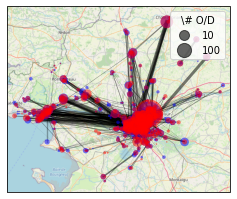

In [6]:
plt.figure(figsize=(4, 4))
plot_journeys_on_map(mobilities, scale=9, subplot_args={})
plt.savefig('../../publications/limits2022/figures/map' + pdl + '.pgf', bbox_inches='tight', dpi=400)

## Émissions en autosolisme

In [33]:
print("Comme calculé par le RPC (kgCO2)", (rpc['distance'] * (1 + rpc['passenger_seats'])).sum() * ADEME_FACTORS["Voiture - Motorisation moyenne - 2018"] / 1000)
mobilities["ghg_car"] = mobilities['passenger_seats'] * mobilities['distance_car'] * ADEME_FACTORS["Voiture - Motorisation moyenne - 2018"] / 1000
print("Calculé par moi", mobilities["ghg_car"].sum())
autosolism_emissions = mobilities["ghg_car"].sum()

Comme calculé par le RPC (kgCO2) (5.6+/-3.3)e+04
Calculé par moi (5.1+/-3.0)e+04


## Émissions en covoiturage

In [8]:
print("Comme calculé par le RPC (kgCO2) :", rpc['distance'].sum() * ADEME_FACTORS["Voiture - Motorisation moyenne - 2018"] / 1000)
print("Calculé par moi (kgCO2) :", ridesharing['distance'].sum() * ADEME_FACTORS['Voiture - Motorisation moyenne - 2018'] / 1000)

Comme calculé par le RPC (kgCO2) : (2.8+/-1.7)e+04
Calculé par moi (kgCO2) : (2.2+/-1.3)e+04


In [32]:
ridesharing_emissions = ridesharing['distance'].sum() * ADEME_FACTORS['Voiture - Motorisation moyenne - 2018'] / 1000

## Comparaison covoiturage / voiture

In [9]:
mobilities_ridesharing = pd.merge(mobilities_ridesharing, car_itineraries, left_on=OD_COL_NAMES, right_index=True)

In [10]:
diff_ridesharing_car = mobilities_ridesharing["time_ridesharing"] - mobilities_ridesharing["time_car"]

In [11]:
print(diff_ridesharing_car.max())

print(diff_ridesharing_car.min())
print(diff_ridesharing_car.mean())

0 days 00:21:05.597000
-1 days +23:59:59.998000
0 days 00:00:26.409074060


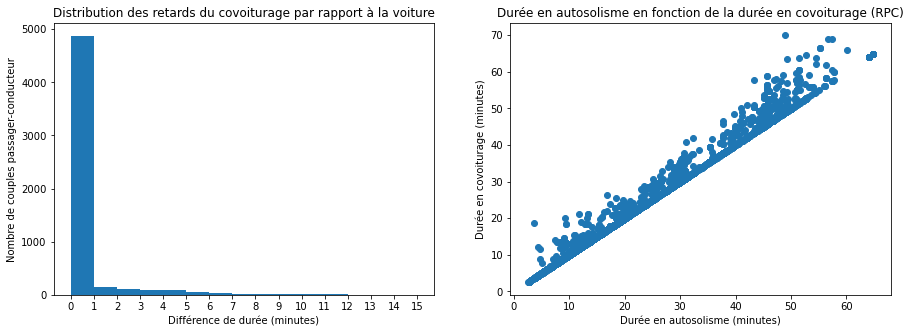

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(diff_ridesharing_car.dt.total_seconds()/60, bins=range(16))
plt.xticks(range(16));
plt.title("Distribution des retards du covoiturage par rapport à la voiture")
plt.xlabel("Différence de durée (minutes)")
plt.ylabel("Nombre de couples passager-conducteur")
plt.subplot(1,2,2)
plt.scatter(mobilities_ridesharing["time_car"].dt.total_seconds()/60, mobilities_ridesharing["time_ridesharing"].dt.total_seconds()/60)
plt.title("Durée en autosolisme en fonction de la durée en covoiturage (RPC)")
plt.xlabel("Durée en autosolisme (minutes)")
plt.ylabel("Durée en covoiturage (minutes)");

In [13]:
mobilities_ridesharing[mobilities_ridesharing["time_ridesharing"].dt.total_seconds() == 0]

Empty DataFrame
Columns: [start_datetime, end_datetime, trip_id, start_datetime_tz, start_lon, start_lat, start_insee, start_postalcode, start_department, start_town, start_country, end_datetime_tz, end_lon, end_lat, end_insee, end_postalcode, end_department, end_town, end_country, passenger_seats, operator_class, distance, duration, end_dayofweek, end_time, distance_ridesharing, time_ridesharing, distance_car, weight, time_car, transfers, snapped_waypoints]
Index: []

[0 rows x 32 columns]

In [14]:
mobilities_ridesharing[mobilities_ridesharing["trip_id"] == '83b070eb-6caa-4a56-8d4a-9db82ae63307'][['start_lon', 'start_lat', 'end_lon', 'end_lat']]

start_lon  start_lat  end_lon  end_lat
journey_id                                        
4863747         -1.63      47.23    -1.57    47.21
4864371         -1.58      47.20    -1.60    47.22
4864686         -1.60      47.22    -1.58    47.20

## Nombre de passagers par véhicule

In [15]:
(rpc.groupby('trip_id').sum('passenger_seats')['passenger_seats'] + 1).value_counts() / rpc.shape[0]

2    0.645489
3    0.103649
4    0.045199
5    0.001815
7    0.000726
Name: passenger_seats, dtype: float64

## Même statistiques sur "partir après une heure donnée"
Les calculs ci-dessous ne considère que ceux qui peuvent prendre les TC. Les itinéraires en TC sont calculés sachant que les voyageurs veulent partir après une certaine heure.

In [ ]:
mobilities["start_dayofweek"] = mobilities["start_datetime"].dt.dayofweek
mobilities["start_time"] =  mobilities["start_datetime"].dt.time
mobilities_pt_only = pd.merge(mobilities, pt, left_on=pt.index.names, right_index=True, how="inner")

print(mobilities_pt_only["passenger_seats"].sum(), "/", mobilities["passenger_seats"].sum(), "voyageurs peuvent prendre les TC")

In [ ]:
calculate_pt_ghg(mobilities_pt_only)
print_ghg(mobilities_pt_only)

mobilities_pt_only["datetime_diff"] = mobilities_pt_only["query_datetime_answered"] - mobilities_pt_only["query_datetime_expected"]
mobilities_pt_only["time_ratio"] = mobilities_pt_only["time_transit"] / mobilities_pt_only["time_car"]
mobilities_pt_only["time_diff"] = mobilities_pt_only["time_transit"] - mobilities_pt_only["time_car"]

<AxesSubplot:title={'center':'Différence temps en TC - temps en voiture'}, xlabel='heures', ylabel='nombre de voyageurs'>

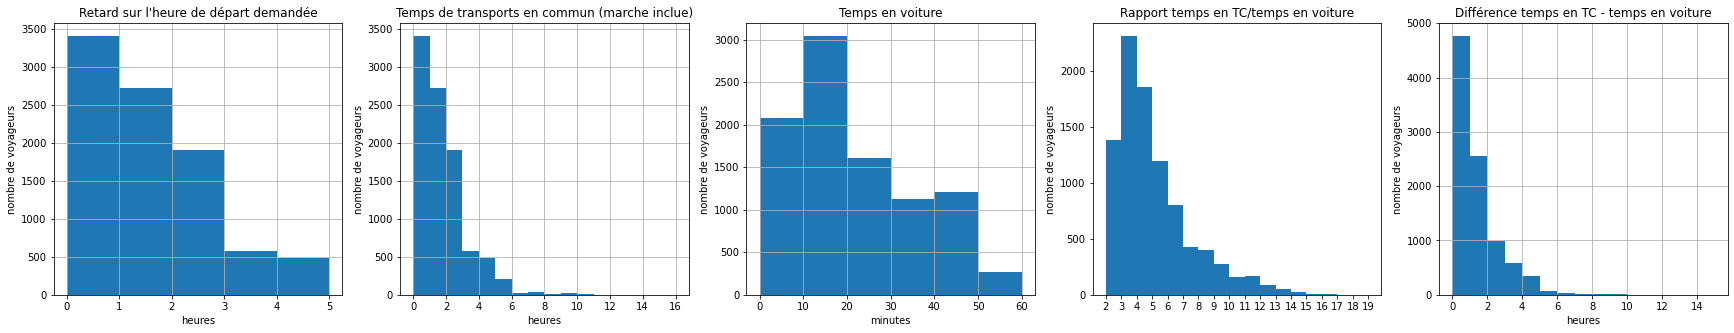

In [18]:
plt.figure(figsize=(30,5))
plt.subplot(1,5,1)
plt.title("Retard sur l'heure de départ demandée")
plt.ylabel("nombre de voyageurs")
plt.xlabel("heures")
(mobilities_pt_only["datetime_diff"].dt.total_seconds()/3600).hist(bins=range(6))
plt.subplot(1,5,2)
plt.title("Temps de transports en commun (marche inclue)")
plt.ylabel("nombre de voyageurs")
plt.xlabel("heures")
(mobilities_pt_only["time_transit"].dt.total_seconds()/3600).hist(bins=range(17))
plt.subplot(1,5,3)
plt.title("Temps en voiture")
plt.ylabel("nombre de voyageurs")
plt.xlabel("minutes")
(mobilities_pt_only["time_car"].dt.total_seconds()/60).hist(bins=range(0, 61, 10))
plt.subplot(1,5,4)
plt.title("Rapport temps en TC/temps en voiture")
plt.ylabel("nombre de voyageurs")
plt.hist((mobilities_pt_only["time_transit"].dt.total_seconds() / mobilities_pt_only["time_car"].dt.total_seconds()), bins=range(2, 20))
plt.xticks(range(2, 20));
plt.subplot(1,5,5)
plt.title("Différence temps en TC - temps en voiture")
plt.ylabel("nombre de voyageurs")
plt.xlabel("heures")
((mobilities_pt_only["time_transit"].dt.total_seconds() - mobilities_pt_only["time_car"].dt.total_seconds())/3600).hist(bins=range(16))

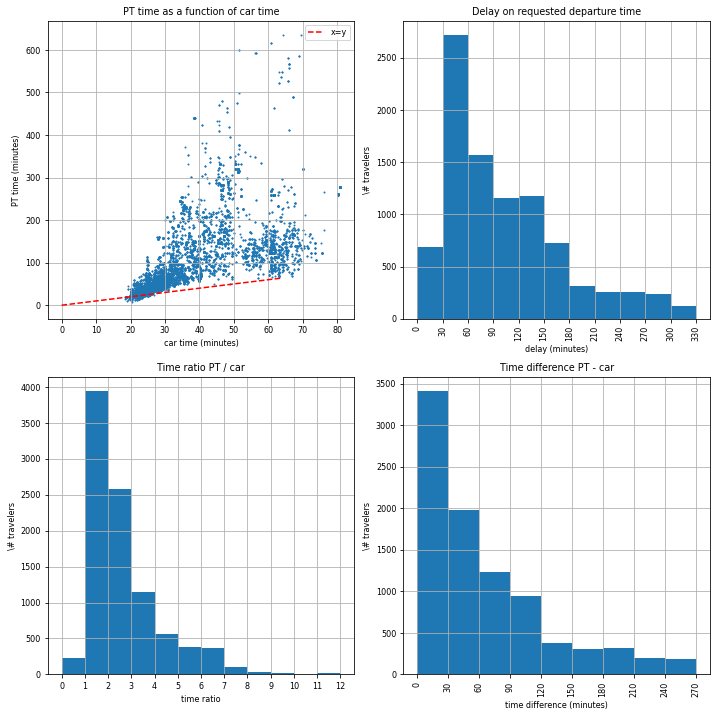

In [19]:
matplotlib.rcParams.update({'font.size': 8})
plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
plt.title("Delay on requested departure time")
plt.ylabel("\# travelers")
plt.xlabel("delay (minutes)")
(mobilities_pt_only["datetime_diff"].dt.total_seconds()/60).hist(bins=range(0,6*60,30))
plt.xticks(range(0, 6*60, 30), rotation=90)

plt.subplot(2,2,3)
plt.title("Time ratio PT / car")
plt.xlabel("time ratio")
plt.ylabel("\# travelers")
plt.hist((mobilities_pt_only["time_transit"].dt.total_seconds() / (mobilities_pt_only["time_car"].dt.total_seconds() + 960)), bins=range(0, 13))
plt.xticks(range(0, 13))
plt.grid(True)

plt.subplot(2,2,4)
plt.title("Time difference PT - car")
plt.ylabel("\# travelers")
plt.xlabel("time difference (minutes)")
((mobilities_pt_only["time_transit"].dt.total_seconds() - (mobilities_pt_only["time_car"].dt.total_seconds() + 960))/60).hist(bins=range(0, 5*60, 30))
plt.xticks(range(0, 5*60, 30), rotation=90);

plt.subplot(2,2,1)
time_car = (mobilities_pt_only["time_car"].dt.total_seconds() + 960) / 60
time_transit = mobilities_pt_only["time_transit"].dt.total_seconds() / 60
c = plt.scatter(time_car, time_transit, s=1)
c.set_rasterized(True)
plt.plot(range(65), "--", color="r", label="x=y")
plt.title("PT time as a function of car time")
plt.xlabel("car time (minutes)")
plt.ylabel("PT time (minutes)")
plt.legend()
plt.grid(True)

plt.tight_layout()
#plt.savefig('../../publications/limits2022/figures/stats_rpc_car_pt.pgf', bbox_inches='tight')

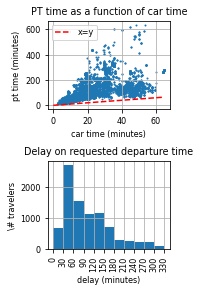

In [20]:
matplotlib.rcParams.update({'font.size': 8})
plt.figure(figsize=(2.5,4.1))
plt.subplot(2,1,2)
plt.title("Delay on requested departure time")
plt.ylabel("\# travelers")
plt.xlabel("delay (minutes)")
(mobilities_pt_only["datetime_diff"].dt.total_seconds()/60).hist(bins=range(0,6*60,30))
plt.xticks(range(0, 6*60, 30), rotation=90)

plt.subplot(2,1,1)
time_car = mobilities_pt_only["time_car"].dt.total_seconds() / 60
time_transit = mobilities_pt_only["time_transit"].dt.total_seconds() / 60
c = plt.scatter(time_car, time_transit, s=1)
c.set_rasterized(True)
plt.plot(range(65), "--", color="r", label="x=y")
plt.title("PT time as a function of car time")
plt.xlabel("car time (minutes)")
plt.ylabel("pt time (minutes)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('../../publications/limits2022/figures/stats_rpc_car_pt' + pdl + '.pgf', bbox_inches='tight', dpi=400)
#plt.savefig('../../redactions/analyse_rpc/figures/statistiques_rpc_voiture_tc.pgf', bbox_inches='tight')

In [21]:
mobilities_pt_only

start_lon  start_lat  end_lon  end_lat  \
4809655      -1.66      47.65    -1.58    47.26   
4859274      -1.66      47.65    -1.58    47.26   
2207         -1.66      47.65    -1.58    47.26   
4828679      -1.66      47.65    -1.58    47.26   
4837583      -1.66      47.65    -1.58    47.26   
...            ...        ...      ...      ...   
834          -1.96      47.38    -1.58    47.19   
790          -1.55      47.22    -1.56    47.23   
796          -1.50      47.13    -1.64    47.37   
805          -1.55      47.26    -1.19    47.36   
819          -1.56      47.25    -1.55    47.25   

                                      trip_id  passenger_seats  \
4809655  a1c68030-b2af-45d1-a699-b3acd4048610                1   
4859274  efa980b1-3087-47ce-8bf9-efd3a4d3041f                1   
2207     efa980b1-3087-47ce-8bf9-efd3a4d3041f                1   
4828679  f82785c4-6e17-4d8d-8b40-3be63cac7c16                1   
4837583  12da6937-630d-4584-bac3-277995e4e218                1   
...                                       ...              ...   
834      1a5e8305-5cf5-43ac-a47c-91511ee87286                1   
790      f82521e5-bef7-4c92-b402-1763fb23466a                1   
796      e86ec867-861d-4c04-9bf8-4cdf4872ec9f                1   
805      083a38df-f458-4806-8d48-a5f255bdb940                1   
819      0cd14b1b-d522-4dba-a312-a7df916d071e                1   

             start_datetime          start_datetime_tz        end_datetime  \
4809655 2021-10-01 05:50:00  2021-10-01T05:50:00+02:00 2021-10-01 06:20:00   
4859274 2021-10-08 05:50:00  2021-10-08T05:50:00+02:00 2021-10-08 06:20:00   
2207    2021-10-08 05:50:00  2021-10-08T05:50:00+02:00 2021-10-08 06:20:00   
4828679 2021-10-04 04:50:00  2021-10-04T04:50:00+02:00 2021-10-04 05:20:00   
4837583 2021-10-05 05:50:00  2021-10-05T05:50:00+02:00 2021-10-05 06:20:00   
...                     ...                        ...                 ...   
834     2021-10-21 07:20:00  2021-10-21T07:20:00+02:00 2021-10-21 07:50:00   
790     2021-10-13 21:00:00  2021-10-13T21:00:00+02:00 2021-10-13 22:10:00   
796     2021-10-26 16:50:00  2021-10-26T16:50:00+02:00 2021-10-26 17:10:00   
805     2021-10-19 17:30:00  2021-10-19T17:30:00+02:00 2021-10-19 18:00:00   
819     2021-10-13 18:40:00  2021-10-13T18:40:00+02:00 2021-10-13 20:30:00   

                   end_datetime_tz  ...          query_datetime_answered  \
4809655  2021-10-01T06:20:00+02:00  ... 2022-01-07 09:36:02.166000+00:00   
4859274  2021-10-08T06:20:00+02:00  ... 2022-01-07 09:36:02.166000+00:00   
2207     2021-10-08T06:20:00+02:00  ... 2022-01-07 09:36:02.166000+00:00   
4828679  2021-10-04T05:20:00+02:00  ... 2022-01-03 09:36:02.166000+00:00   
4837583  2021-10-05T06:20:00+02:00  ... 2022-01-04 09:36:02.166000+00:00   
...                            ...  ...                              ...   
834      2021-10-21T07:50:00+02:00  ... 2022-01-06 08:27:02.900000+00:00   
790      2021-10-13T22:10:00+02:00  ... 2022-01-05 20:17:33.996000+00:00   
796      2021-10-26T17:10:00+02:00  ... 2022-01-04 19:18:55.013000+00:00   
805      2021-10-19T18:00:00+02:00  ... 2022-01-04 17:50:35.827000+00:00   
819      2021-10-13T20:30:00+02:00  ... 2022-01-05 17:53:29.932000+00:00   

        leg_count_walk  leg_count_transit            ghg_0     ghg_2  \
4809655              3                  2        1.1+/-0.5  0.000000   
4859274              3                  2        1.1+/-0.5  0.000000   
2207                 3                  2        1.1+/-0.5  0.000000   
4828679              3                  2        1.1+/-0.5  0.000000   
4837583              3                  2        1.1+/-0.5  0.000000   
...                ...                ...              ...       ...   
834                  3                  2    0.196+/-0.007  0.183482   
790                  2                  1  0.0044+/-0.0027  0.000000   
796                  7                  6        1.6+/-0.9  0.000000   
805                  2           

TC avec moins de 1 heure de retard : 3403
Différence de trajet < 1 h : 4767
Les deux : 3403


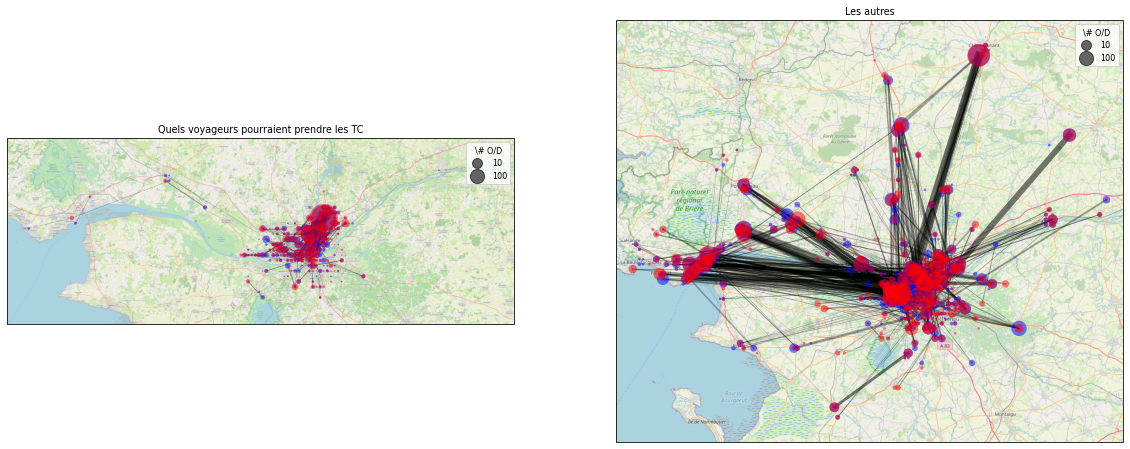

In [22]:
arrivaldifffilter = mobilities_pt_only["datetime_diff"].dt.total_seconds() < (3600)
print("TC avec moins de 1 heure de retard :", mobilities_pt_only[arrivaldifffilter]['passenger_seats'].sum())

difftimefilter = (mobilities_pt_only["time_transit"].dt.total_seconds() - mobilities_pt_only["time_car"].dt.total_seconds()) < (60 * 60)
print("Différence de trajet < 1 h :", mobilities_pt_only[difftimefilter]['passenger_seats'].sum())

print("Les deux :", mobilities_pt_only[difftimefilter & arrivaldifffilter]['passenger_seats'].sum())

plt.figure(figsize=(20, 25))
plot_journeys_on_map(mobilities_pt_only[difftimefilter & arrivaldifffilter], scale=12, subplot_args=[2,2,1])
plt.title("Quels voyageurs pourraient prendre les TC");
plot_journeys_on_map(mobilities_pt_only[~(difftimefilter & arrivaldifffilter)], scale=10, subplot_args=[2,2,2])
plt.title("Les autres");

In [23]:
mobilities_pt_only[difftimefilter & arrivaldifffilter].iloc[0]

start_lon                                                 -1.52
start_lat                                                 47.21
end_lon                                                   -1.45
end_lat                                                   47.27
trip_id                    bb3889e7-6035-4d8a-8e9a-ea6cad301e66
passenger_seats                                               1
start_datetime                              2021-10-04 06:30:00
start_datetime_tz                     2021-10-04T06:30:00+02:00
end_datetime                                2021-10-04 06:40:00
end_datetime_tz                       2021-10-04T06:40:00+02:00
start_insee                                               44109
end_insee                                                 44204
driver                                                    False
distance_car                                          11686.691
weight                                               899.454518
time_car                                

### Distance de marche

<AxesSubplot:title={'center':'Distance de marche en prenant les tc'}, xlabel='distance (m)', ylabel='nombre de voyageurs'>

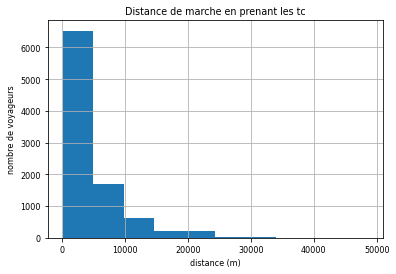

In [24]:
plt.figure()
plt.title("Distance de marche en prenant les tc")
plt.xlabel("distance (m)")
plt.ylabel("nombre de voyageurs")
mobilities_pt_only["distance_walk"].hist()

Text(0.5, 1.0, 'Nombre de trajets par nombre de différents TC pris\n(exemple : 2 lignes de bus, 1 ligne de tram = 3 TC pris)')

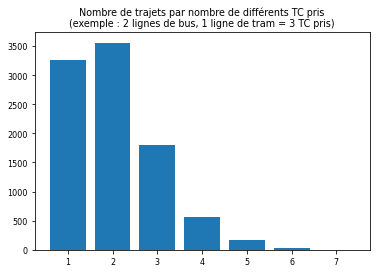

In [25]:
plt.bar(mobilities_pt_only["leg_count_transit"].value_counts().index, mobilities_pt_only["leg_count_transit"].value_counts().values)
plt.title("Nombre de trajets par nombre de différents TC pris\n(exemple : 2 lignes de bus, 1 ligne de tram = 3 TC pris)")

# Modèle de choix simple

Spécification : dans l'ordre de priorité, les émissions associées à chaque trajet le sont selon les conditions suivantes :

1) conditions mobilité douce (0 CO2/km) : durée vélo < 30 min
2) conditions TC : durée TC < 1 h
3) (conditions covoiturage : durée covoiturage < 1 h)
4) autosolisme pour tous les autres

In [26]:
mobilities = pd.merge(mobilities, pt, left_on=pt.index.names, right_index=True, how="left") # ajout des pt
calculate_pt_ghg(mobilities)
mobilities = pd.merge(mobilities, itineraries_bike, left_on=['start_lon', 'start_lat', 'end_lon', 'end_lat'], right_index=True, how="left") # ajout du vélo

In [27]:
condition_transit = mobilities["time_transit"] < pd.Timedelta(60, unit="min")
#condition_transit = mobilities["time_transit"] < 3 * mobilities["time_car"]
#condition_transit = (mobilities["time_transit"] < 2 * mobilities["time_car"]) | (mobilities["time_transit"] < pd.Timedelta(60, unit="min"))
condition_soft = mobilities["time_bike"] < pd.Timedelta(30, unit="min")

mobilities["choice"] = "car"
mobilities["ghg_choice"] = mobilities["ghg_car"]

mobilities.loc[condition_transit, ["choice"]] = "pt"
mobilities.loc[condition_transit, ["ghg_choice"]] = mobilities["ghg_pt"]

mobilities.loc[condition_soft, ["choice"]] = "soft"
mobilities.loc[condition_soft, ["ghg_choice"]] = 0

mobilities["ghg_choice_total"] = mobilities["passenger_seats"] * mobilities["ghg_choice"]

choices_stats = mobilities.groupby(["choice"]).agg({'passenger_seats': 'sum', 'ghg_choice_total': 'sum'})
choices_stats["passenger_seats_share"] = choices_stats["passenger_seats"] / mobilities["passenger_seats"].sum()

In [28]:
mobilities[mobilities["choice"] == "soft"]["time_bike"]

4809836   0 days 00:20:43.990000
4935242   0 days 00:20:43.990000
4944711   0 days 00:20:43.990000
4968306   0 days 00:20:43.990000
1025      0 days 00:20:43.990000
                   ...          
767       0 days 00:12:17.269000
784       0 days 00:06:34.656000
790       0 days 00:06:36.802000
819       0 days 00:05:32.546000
822       0 days 00:17:25.480000
Name: time_bike, Length: 2874, dtype: timedelta64[ns]

In [34]:
cond_emissions = choices_stats['ghg_choice_total'].sum()

In [30]:
#choices_stats

In [35]:
avoided_emissions = cond_emissions - ridesharing_emissions

In [36]:
avoided_emissions

23366.120745940356+/-13572.120119572719